In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
df_m = pd.read_csv('/content/Features_Oncology - Sheet1.csv')
df_m.shape

(21165, 14)

In [ ]:
df_m.head()

,Perimeter,Area,Rect_area,contrast,dissimilarity,homogeneity,energy,correlation,mean_density,std_density,lung_volume,uniformity,sift_keypoints,C_class
0,534.132031,9960.0,13877.291890,0.018610,0.018610,0.990695,0.752653,0.955223,74.337387,115.887819,16.708421,0.896859,39,0
1,549.504614,12875.0,18189.437740,0.019863,0.019863,0.990069,0.717628,0.957361,93.193130,122.797755,26.259631,0.889967,46,0
2,445.320848,6863.5,9397.298228,0.016524,0.016524,0.991738,0.809099,0.949845,52.485580,103.097463,8.329153,0.906535,34,0
3,576.173663,14197.5,19910.424450,0.019943,0.019943,0.990028,0.702918,0.959012,105.550919,125.596528,33.685644,0.886274,37,0
4,383.421354,5712.0,7281.930782,0.013882,0.013882,0.993059,0.832104,0.952819,45.232773,97.408179,6.186247,0.921512,33,0


In [ ]:
df_g2 = pd.read_csv('/content/FInal_graph_data_covid19_radiopathy - Sheet1.csv')
df_g2.head()

,Features,Nodes,source,target
0,Perimeter,0.0,0,1
1,Area,1.0,0,2
2,Rect_area,2.0,0,3
3,contrast,3.0,0,4
4,dissimilarity,4.0,0,5


In [ ]:
class_values = sorted(df_m["C_class"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(df_g2["Nodes"].unique()))}
print(paper_idx)


{0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8, 9.0: 9, 10.0: 10, 11.0: 11, 12.0: 12, nan: 13}


In [ ]:
train_data, test_data = [], []

for _, group_data in df_m.groupby("C_class"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (10419, 14)
Test data shape: (10746, 14)


In [ ]:
hidden_units = [64, 64]
learning_rate = 0.0007
dropout_rate = 0.3
num_epochs = 100
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,

    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:


# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["C_class"]
y_test = test_data["C_class"]

In [ ]:
num_classes = 4

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features            │ (None, 14)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block1 (Sequential)   │ (None, 64)             │          5,432 │ input_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block2 (Sequential)   │ (None, 64)             │          8,832 │ ffn_block1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection2 (Add)    │ (None, 64)             │              0 │ ffn_block1[0][0],      │
│                           │                        │                │ ffn_block2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block3 (Sequential)   │ (None, 64)             │          8,832 │ skip_connection2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection3 (Add)    │ (None, 64)             │              0 │ skip_connection2[0][0… │
│                           │                        │                │ ffn_block3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block4 (Sequential)   │ (None, 64)             │          8,832 │ skip_connection3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection4 (Add)    │ (None, 64)             │              0 │ skip_connection3[0][0… │
│                           │                        │                │ ffn_block4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block5 (Sequential)   │ (None, 64)             │          8,832 │ skip_connection4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection5 (Add)    │ (None, 64)             │              0 │ skip_connection4[0][0… │
│                           │                        │                │ ffn_block5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logits (Dense)            │ (None, 4)              │            260 │ skip_connection5[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 41,020 (160.23 KB)

 Trainable params: 39,840 (155.62 KB)

 Non-trainable params: 1,180 (4.61 KB)

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - acc: 0.2483 - loss: 3.3927 - val_acc: 0.4760 - val_loss: 1.9800
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.6213 - loss: 1.1094 - val_acc: 0.4875 - val_loss: 0.9165
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.6856 - loss: 0.8761 - val_acc: 0.4818 - val_loss: 0.7630
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.7097 - loss: 0.7735 - val_acc: 0.5765 - val_loss: 0.6815
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.7285 - loss: 0.7286 - val_acc: 0.7268 - val_loss: 0.6384
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.7494 - loss: 0.6658 - val_acc: 0.7556 - val_loss: 0.6199
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.7668 - loss: 0.6280 - val_acc: 0.7274 - val_loss: 0.6817
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - acc: 0.7550 - loss: 0.6289 - val_acc: 0.7550 - val_loss: 0.6830
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - a

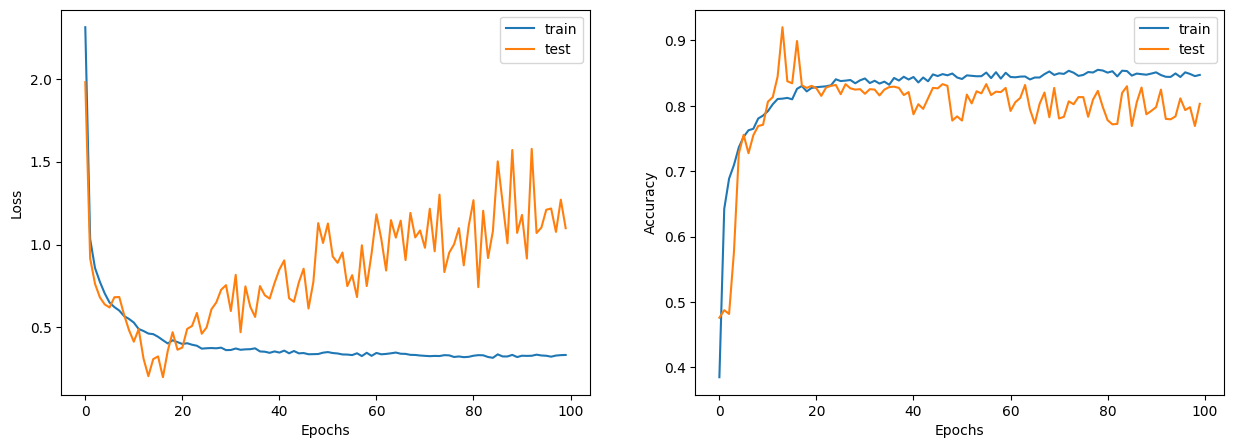

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 79.19%


<ipython-input-47-c34f5036ac09>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Absolute Pearson Correlation between Different Features')

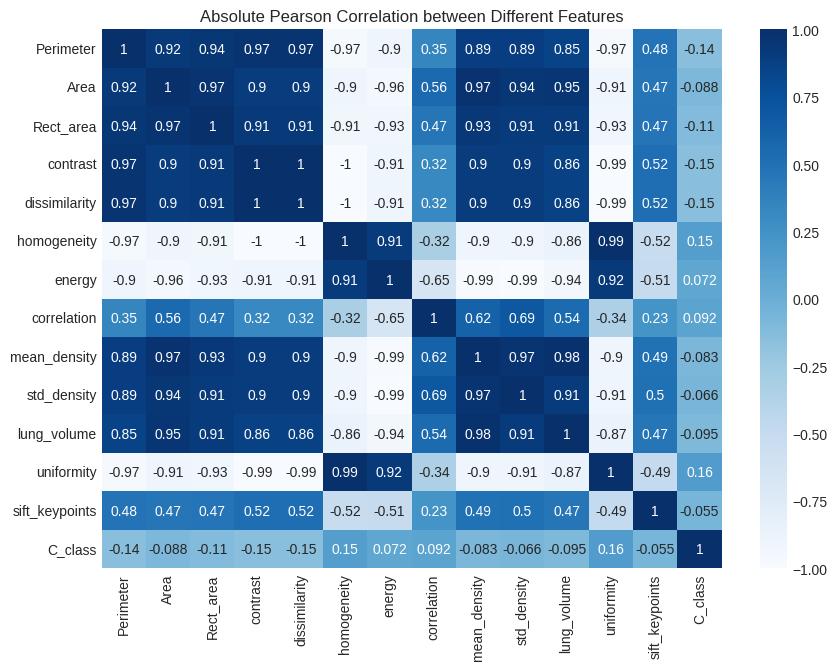

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the features from a CSV file
df_g = pd.read_csv('/content/Features_Oncology - Sheet1.csv')

# Normalize the feature values
df_norm = (df_g - df_g.mean()) / df_g.std()

# Compute the correlation matrix
corr_matrix = df_norm.corr()

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")

plt.figure(figsize = (10,7))
sns.heatmap(df_g.corr(), annot=True, cmap="Blues")
plt.title('Absolute Pearson Correlation between Different Features')


In [ ]:
# Step 2: Create a list of nodes from the column names in the DataFrame
node_features = list(df_g.columns)

# Step 3: Create a list of edges from the data in the DataFrame
edges = []
for i, col1 in enumerate(df_g.columns):
    for j, col2 in enumerate(df_g.columns):
        if i < j:
          edges.append((col1, col2))
            #corr = df_g[col1].corr(df_g[col2])
           # if abs(corr) >= 0.45:  # Threshold for significant correlation


edge_weights = edges
graph_info = (node_features, edges, edge_weights)

In [ ]:
print(edges)

[('Perimeter', 'Area'), ('Perimeter', 'Rect_area'), ('Perimeter', 'contrast'), ('Perimeter', 'dissimilarity'), ('Perimeter', 'homogeneity'), ('Perimeter', 'energy'), ('Perimeter', 'correlation'), ('Perimeter', 'mean_density'), ('Perimeter', 'std_density'), ('Perimeter', 'lung_volume'), ('Perimeter', 'uniformity'), ('Perimeter', 'sift_keypoints'), ('Perimeter', 'C_class'), ('Area', 'Rect_area'), ('Area', 'contrast'), ('Area', 'dissimilarity'), ('Area', 'homogeneity'), ('Area', 'energy'), ('Area', 'correlation'), ('Area', 'mean_density'), ('Area', 'std_density'), ('Area', 'lung_volume'), ('Area', 'uniformity'), ('Area', 'sift_keypoints'), ('Area', 'C_class'), ('Rect_area', 'contrast'), ('Rect_area', 'dissimilarity'), ('Rect_area', 'homogeneity'), ('Rect_area', 'energy'), ('Rect_area', 'correlation'), ('Rect_area', 'mean_density'), ('Rect_area', 'std_density'), ('Rect_area', 'lung_volume'), ('Rect_area', 'uniformity'), ('Rect_area', 'sift_keypoints'), ('Rect_area', 'C_class'), ('contrast'

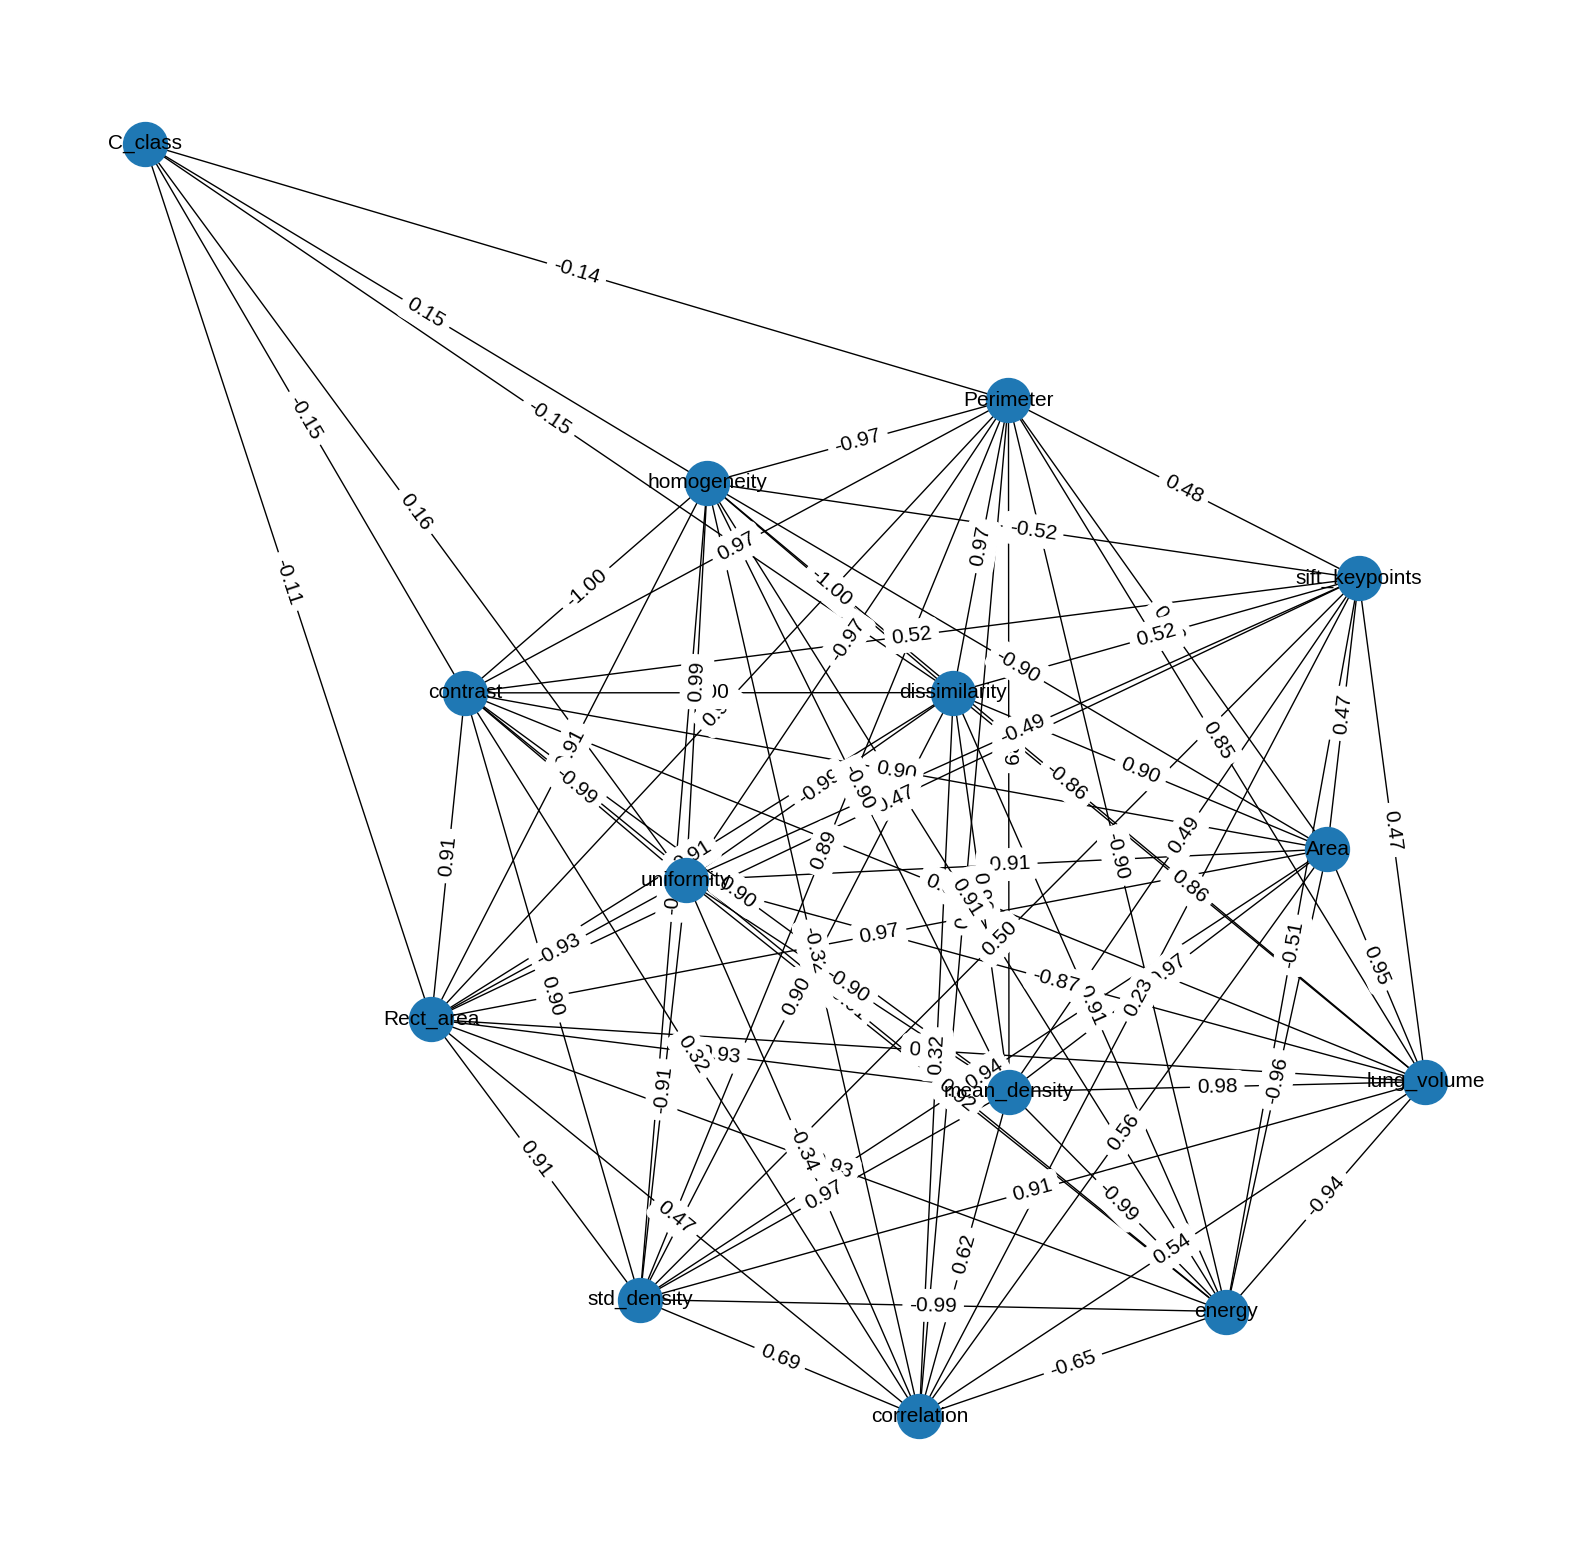

In [ ]:
# Step 2: Create a list of nodes from the column names in the DataFrame
nodes = list(df_g.columns)

# Step 3: Create a list of edges from the data in the DataFrame
edges = []
for i, col1 in enumerate(df_g.columns):
    for j, col2 in enumerate(df_g.columns):
        if i < j:

          corr = df_g[col1].corr(df_g[col2])
          if abs(corr) >= 0.45:  # Threshold for significant correlation
              edges.append((col1, col2))  # Threshold for significant correlation


# Step 4: Create a NetworkX graph object and add the nodes and edges to it
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Step 5: Draw the graph using a layout algorithm and save or show the figure
pos = nx.spring_layout(G, seed=42) # Using seed for reproducibility
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw_networkx(G, pos, with_labels=True, node_size=1000, ax=ax, font_size=15)
edge_labels = {(u, v): f'{df_g[u].corr(df_g[v]):.2f}' for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, ax=ax)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15, ax=ax)
plt.axis('off')
plt.show()

In [ ]:
print(nodes)
print(edges)

['Perimeter', 'Area', 'Rect_area', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'mean_density', 'std_density', 'lung_volume', 'uniformity', 'sift_keypoints', 'C_class']
[('Perimeter', 'Area'), ('Perimeter', 'Rect_area'), ('Perimeter', 'contrast'), ('Perimeter', 'dissimilarity'), ('Perimeter', 'homogeneity'), ('Perimeter', 'energy'), ('Perimeter', 'correlation'), ('Perimeter', 'mean_density'), ('Perimeter', 'std_density'), ('Perimeter', 'lung_volume'), ('Perimeter', 'uniformity'), ('Perimeter', 'sift_keypoints'), ('Perimeter', 'C_class'), ('Area', 'Rect_area'), ('Area', 'contrast'), ('Area', 'dissimilarity'), ('Area', 'homogeneity'), ('Area', 'energy'), ('Area', 'correlation'), ('Area', 'mean_density'), ('Area', 'std_density'), ('Area', 'lung_volume'), ('Area', 'uniformity'), ('Area', 'sift_keypoints'), ('Rect_area', 'contrast'), ('Rect_area', 'dissimilarity'), ('Rect_area', 'homogeneity'), ('Rect_area', 'energy'), ('Rect_area', 'correlation'), ('Rect_area', 'mea

In [ ]:
df_g2 = pd.read_csv('/content/FInal_graph_data_covid19_radiopathy - Sheet1.csv')

In [ ]:
hidden_units = [64, 64]
learning_rate = 0.00007
dropout_rate = 0.4
num_epochs = 100
batch_size = 128

In [ ]:
edges = df_g2[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    df_g.sort_values("C_class")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 71)
Nodes shape: (21165, 14)


In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
         # Create the third GraphConv layer.
        self.conv3 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv3",
        )
        self.conv4 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv4",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Apply the third graph conv layer.
        x3 = self.conv3((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x3 + x
        # Apply the fourth graph conv layer.
        x4 = self.conv4((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x4 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

In [ ]:
x_train = train_data.C_class.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 64s 666ms/step - acc: 0.2628 - loss: 846.7891 - val_acc: 0.4754 - val_loss: 26.2371
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 636ms/step - acc: 0.4807 - loss: 14.3219 - val_acc: 0.7690 - val_loss: 2.7794
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 625ms/step - acc: 0.8759 - loss: 2.2226 - val_acc: 0.9347 - val_loss: 1.9801
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 617ms/step - acc: 0.9164 - loss: 1.8491 - val_acc: 0.7690 - val_loss: 1.8467
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 609ms/step - acc: 0.9261 - loss: 1.5773 - val_acc: 0.9347 - val_loss: 1.4416
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 613ms/step - acc: 0.9089 - loss: 1.3847 - val_acc: 0.9347 - val_loss: 1.1555
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 613ms/step - acc: 0.9084 - loss: 1.0765 - val_acc: 0.9347 - val_loss: 0.8065
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 84s 637ms/step - acc: 0.9173 - loss: 0.7765 - val_acc: 0.9347 - val_loss: 0.5343
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━

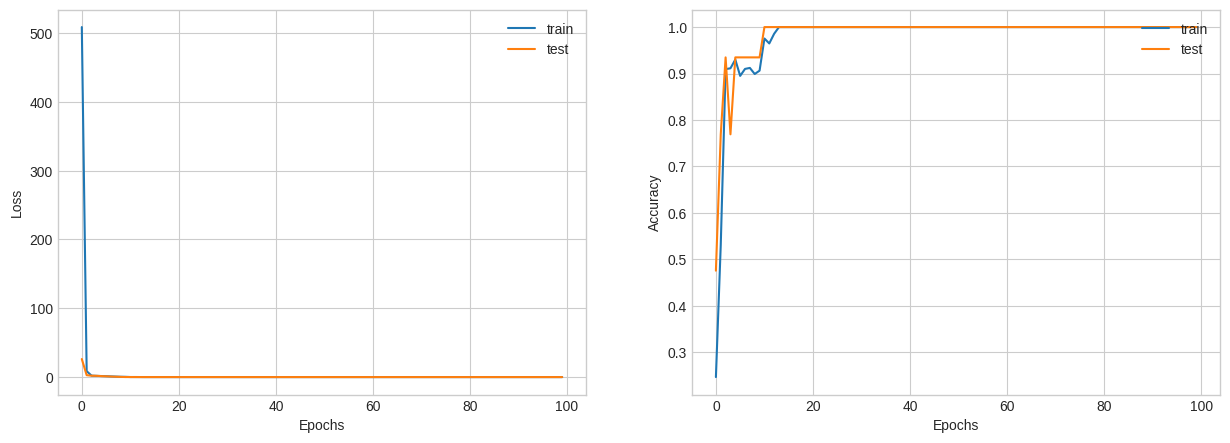

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.C_class.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%");

Test accuracy: 100.0%
